In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
from scipy import special

# Define maximum number of iterations
MAX_ITER = 100

# Define range of complex numbers
RE_START = -2
RE_END = 0.5
IM_START = -1.1
IM_END = 1.1

# Compute Mandelbrot set as f_c(z) = z^2 + c while z is in 
# range [-2, 2] and n below the maximum number of iterations
def mandelbrot(c, max_iter):
    z = n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z*z + c
        n += 1
    return n

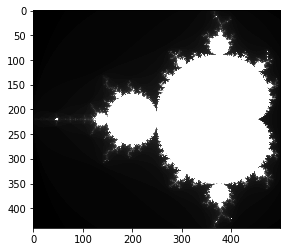

In [2]:
# Compute number of iterations possible in Mandelbrot calculation for 
# complex numbers in range [RE_START + IM_START * i, RE_END + IM_END * i]
image = np.zeros((440, 500))
for x, y in np.ndindex(image.shape):
    c = complex(RE_START + (y / image.shape[1]) * (RE_END - RE_START),
                    IM_START + (x / image.shape[0]) * (IM_END - IM_START))
    image[x,y] = mandelbrot(c, 100)
    
plt.imshow(image, cmap='gray')
plt.show()

In [75]:
# Take s Monte Carlo samples from the Mandelbrot set
def monte_carlo_integration(i=100, s=100, sampling_method='random'):
    if sampling_method == 'latin_hypercube':
        samples = latin_hypercube_sampling(s)
    elif sampling_method == 'orthogonal':
        samples = orthogonal_sampling(s)
    else:
        samples = np.random.random((s,2))
    
    samples[:,0] = samples[:,0] * (RE_END - RE_START) + RE_START
    samples[:,1] = samples[:,1] * (IM_END - IM_START) + IM_START

    n = np.vectorize(mandelbrot)(samples.view(dtype=np.complex128), i)
    return (n == i).sum() / s * (RE_END - RE_START) * (IM_END - IM_START)

In [62]:
def latin_hypercube_sampling(n_samples, n_dimensions=2):
    samples = np.random.random((n_samples, n_dimensions))
    perms = np.array([np.random.permutation(range(n_samples)) for _ in range(n_dimensions)]).T
    return (samples + perms) / n_samples

In [63]:
def orthogonal_sampling(n_samples, n_dimensions=2):
    n_subspaces = np.sqrt(n_samples)
    if round(n_subspaces) != n_subspaces:
        raise ValueError('Square root of number of samples not a whole number')
    
    xlist = np.arange(n_samples).reshape(int(n_subspaces),int(n_subspaces))
    ylist = np.arange(n_samples).reshape(int(n_subspaces),int(n_subspaces))
    
    xlist = np.random.permutation(xlist)
    ylist = np.random.permutation(ylist)
    
    samples = np.random.random((n_samples, n_dimensions))
    perms = np.array([[xlist[index], ylist[index[::-1]]] for index,_ in np.ndenumerate(xlist)])
    return (samples + perms) / n_samples

## Plotting the area

In [185]:
def plot_samples(s_list, iterations=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())

    areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip([iterations]*len(s_list), s_list)))
    plt.plot(s_list, areas, '.', label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, s_list[0], s_list[-1], label = "Theoretical Mandelbrot area")
    plt.xlabel("Samples")
    plt.ylabel("Surface area")
    plt.yscale('log')
    # plt.savefig("Convergence_samples", dpi=500)
    plt.legend()
    plt.show()

    pool.close()

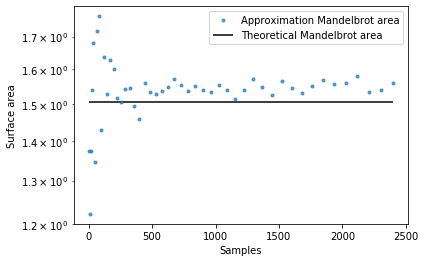

In [186]:
plot_samples(np.arange(1,50)**2, 100, 'orthogonal')

In [183]:
def plot_iterations(i_list, samples=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())
    
    areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip(i_list, [samples]*len(i_list))))
    plt.plot(i_list, areas, '.', label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, i_list[0], i_list[-1], label = "Theoretical Mandelbrot area")
    plt.xlabel("Iterations")
    plt.ylabel("Surface area")
    plt.yscale('log')
    plt.legend()
    # plt.savefig("Convergence_iterations.png", dpi=500)
    plt.show()
    
    pool.close()

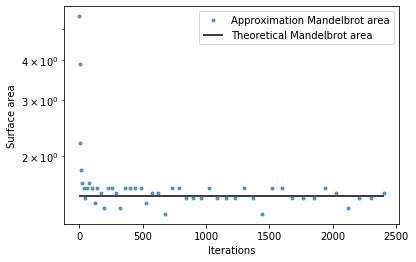

In [184]:
plot_iterations(np.arange(1,50)**2, 100, 'orthogonal')

## Plotting the variance

In [177]:
def plot_samples_variance(s_list, iterations=100, runs=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())

    all_areas = []
    for i in range(runs):
        areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip(s_list, [iterations]*len(s_list))))
        all_areas.append(areas)

    mean = np.mean(all_areas, axis=0)
    variance = np.var(all_areas, axis=0)

    plt.plot(s_list, mean, label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, s_list[0], s_list[-1], label = "Theoretical Mandelbrot area")
    plt.xlabel("Samples")
    plt.ylabel("Surface area")
    plt.ylabel('log')
    plt.fill_between(s_list, mean - variance, mean + variance, alpha = 0.3)
    plt.legend()
    # plt.savefig("Convergence_iterations_variance.png", dpi=500)
    plt.show()

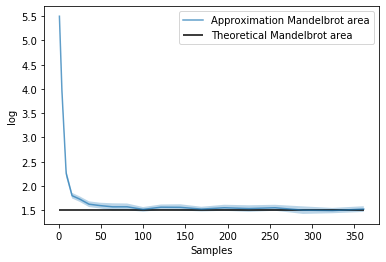

In [178]:
plot_samples_variance(np.arange(1,20)**2)

In [175]:
def plot_iterations_variance(i_list, samples=100, runs=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())

    all_areas = []
    for i in range(runs):
        areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip(i_list, [samples]*len(i_list))))
        all_areas.append(areas)

    mean = np.mean(all_areas, axis=0)
    variance = np.var(all_areas, axis=0)

    plt.plot(i_list, mean, label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, i_list[0], i_list[-1], label = "Theoretical Mandelbrot area")
    plt.xlabel("Iterations")
    plt.ylabel("Surface area")
    plt.ylabel('log')
    plt.fill_between(i_list, mean - variance, mean + variance, alpha = 0.3)
    plt.legend()
    # plt.savefig("Convergence_iterations_variance.png", dpi=500)
    plt.show()

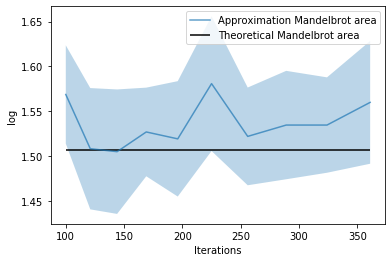

In [176]:
plot_iterations_variance(np.arange(10,20)**2)